# Car resales price prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from itertools import permutations


In [2]:
# Load training and test datasets
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [3]:
train_df.head()

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price
0,1292132,Land Rover Range Rover Velar 3.0A Si6 R-Dynami...,land rover,range,"1 owner, no repairs needed! it looks great, in...",2018.0,NaN,08-mar-2018,suv,parf car,...,96000.0,88906.0,132031.0,NaN,NaN,uncategorized,3l supercharged v6 p380 engine at 375bhp/450nm...,"2 x massage/memory/cooling & warmer seat, rear...",NaN,193788.0
1,1294696,Mercedes-Benz C-Class C200 Sport Premium Sunroof,mercedes-benz,c200,rare beautiful white c200 sport premium sunroo...,2017.0,NaN,28-dec-2017,luxury sedan,"parf car, premium ad car",...,85680.0,40678.0,43950.0,NaN,NaN,uncategorized,"2.0l 4 cylinders inline turbocharged engine, p...","multi function steering, electric tailgate, re...",NaN,96800.0
2,1311717,Honda Odyssey 2.4A (COE till 09/2027),honda,odyssey,comes with warranty. full service done.,2007.0,NaN,19-sep-2007,mpv,"coe car, premium ad car, low mileage car",...,138000.0,27994.0,30794.0,NaN,NaN,uncategorized,"2.4l k24a 4 cylinders inline dohc i-vtec, 5 sp...","cruise control, touchscreen audio, reverse cam...",NaN,39800.0
3,1310068,Toyota Corolla Altis 1.6A (COE till 12/2028),toyota,altis,0,2008.0,NaN,15-dec-2008,mid-sized sedan,"coe car, premium ad car",...,160000.0,16084.0,16084.0,NaN,NaN,uncategorized,super fuel efficient 1.6l 16 valves dohc vvt-i...,"leather seats, pioneer dvd audio system with r...",NaN,44800.0
4,1325280,Lexus GS300 (COE till 06/2026),lexus,gs,wear and tear done up. well maintained and reg...,2006.0,NaN,22-dec-2006,luxury sedan,"coe car, premium ad car",...,183000.0,50414.0,55456.0,NaN,NaN,uncategorized,"powerful 3.0l v6 engine, 227bhp, 6 speed , key...",premium upholstery electric seats. memory seat...,NaN,25800.0


In [4]:
test_df.head()

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,dereg_value,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price
0,1303772,Honda Vezel 1.5A X,honda,vezel,4614,2015.0,NaN,29-apr-2015,suv,parf car,...,9582.0,112000.0,19229.0,9229.0,NaN,NaN,uncategorized,"powerful 1.5l i-vtec engine producing 128bhp, ...","pioneer touch screen with reverse camera, 16"" ...",NaN
1,1323166,Mazda 3 1.6A SP (COE till 10/2027),mazda,3,extremely well maintained and in pristine cond...,2007.0,NaN,26-oct-2007,mid-sized sedan,"coe car, premium ad car, low mileage car",...,13644.0,120000.0,14347.0,15782.0,NaN,NaN,uncategorized,fuel efficient 1.6l 4-cylinder inline 16-valve...,"multi-function steering wheel, keyless entry, ...",NaN
2,1308405,MINI Cooper S Countryman 2.0A,mini,cooper,1 owner! beautiful island blue color! eurokars...,2019.0,NaN,27-mar-2020,sports car,parf car,...,54818.0,43000.0,39863.0,47809.0,NaN,NaN,uncategorized,"output of 141kw, 189bhp at 5000rpm to 6000rpm,...","18"" sports rims, sports leather seats, navigat...",NaN
3,1216706,Toyota Vios 1.5A G,toyota,vios,fully agent maintain! genuine low mileage at 5...,2019.0,NaN,28-jun-2019,mid-sized sedan,"parf car, premium ad car",...,26363.0,53300.0,15573.0,15573.0,NaN,NaN,uncategorized,"1.5l 4 cylinder 16 valves dohc vvt-i engine, 7...","push start button, toyota factory player, reve...",NaN
4,1298206,Mazda 3 HB 1.5A,mazda,3,workshop check/sta evaluation available. accid...,2015.0,NaN,19-nov-2015,hatchback,"parf car, premium ad car",...,15197.0,149000.0,18097.0,13097.0,NaN,NaN,uncategorized,1.5l 4 cylinder inline dohc 16 valves skyactiv...,factory fitted audio with audio & multi functi...,NaN


Check missing values

In [5]:
def print_numerical_missing(df):
    numerical_columns = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'bool']).columns
    missing_stats = {}
    
    print("\nMissing Percentages for Numerical Columns:")
    print("-" * 50)
    
    for col in numerical_columns:
        missing_percent = df[col].isnull().mean() * 100
        missing_stats[col] = missing_percent
        print(f"{col:<30} {missing_percent:.2f}%")
    
    return missing_stats
def numericalColumns(train_df):
    numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
    return numerical_columns
def categoricalColumns(train_df):
    categorical_columns = [col for col in train_df.columns if train_df[col].dtype == 'object']
    return categorical_columns
def missing_columns(train_df,columns):
    total_rows = train_df.shape[0]
    print("Total rows:", total_rows)
    missing_values = train_df[columns].isnull().sum()
    missing_percentages = (missing_values / total_rows) * 100
    print("\nMissing values and percentages for columns:")
    print(pd.concat([missing_values, missing_percentages], axis=1, keys=['Missing Values', '% Missing']))
missing_columns(train_df,numericalColumns(train_df))
missing_columns(train_df,categoricalColumns(train_df))

Total rows: 25000

Missing values and percentages for columns:
                  Missing Values  % Missing
listing_id                     0      0.000
manufactured                   7      0.028
curb_weight                  307      1.228
power                       2640     10.560
engine_cap                   596      2.384
no_of_owners                  18      0.072
depreciation                 507      2.028
coe                            0      0.000
road_tax                    2632     10.528
dereg_value                  220      0.880
mileage                     5304     21.216
omv                           64      0.256
arf                          174      0.696
indicative_price           25000    100.000
price                          0      0.000
Total rows: 25000

Missing values and percentages for columns:
                   Missing Values  % Missing
title                           0      0.000
make                         1316      5.264
model                           0  

## Data cleaning

 Drop unwanted columns like listing_id, indicative_price

In [6]:
train_df=train_df.drop(['listing_id', 'indicative_price','eco_category'], axis=1)
test_df=test_df.drop(['listing_id', 'indicative_price','eco_category'], axis=1)

Standarize columns like title

In [7]:
#train_df = train_df[train_df['category'] != '-']
train_df['title'] = train_df['title'].str.lower()
test_df['title'] = test_df['title'].str.lower()

In [8]:
print(len(train_df.columns))
numerical_columns = numericalColumns(train_df)
categorical_columns = categoricalColumns(train_df)
print(numerical_columns)
print(categorical_columns)
print(len(numerical_columns))
print(len(categorical_columns))

27
Index(['manufactured', 'curb_weight', 'power', 'engine_cap', 'no_of_owners',
       'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage', 'omv',
       'arf', 'price'],
      dtype='object')
['title', 'make', 'model', 'description', 'original_reg_date', 'reg_date', 'type_of_vehicle', 'category', 'transmission', 'fuel_type', 'opc_scheme', 'lifespan', 'features', 'accessories']
13
14


## EDA

Check unique types

In [9]:
unique_titles = train_df['title'].unique()
print(len(unique_titles))
train_df['title'] = train_df['title'].str.split('(').str[0].str.strip().str.lower()
unique_titles = train_df['title'].unique()
print(unique_titles)

7256
['land rover range rover velar 3.0a si6 r-dynamic sunroof'
 'mercedes-benz c-class c200 sport premium sunroof' 'honda odyssey 2.4a'
 ... 'mercedes-benz e-class e300e plug-in hybrid amg line'
 'mazda cx-9 2.5a turbo luxury' 'bmw x7 xdrive40i 7-seater']


Check unique categories

In [10]:
all_values = train_df['category'].str.split(',').explode().str.strip()

# Step 2: Find unique values by converting to a set and count them
unique_values = all_values.unique()
total_unique_values = len(unique_values)

print("Total unique values:", total_unique_values)
print("Unique values:", unique_values)

Total unique values: 16
Unique values: ['parf car' 'premium ad car' 'coe car' 'low mileage car' 'consignment car'
 'rare & exotic' '-' 'sgcarmart warranty cars' 'opc car'
 'imported used vehicle' 'vintage cars' 'hybrid cars' 'electric cars'
 'almost new car' 'direct owner sale' 'sta evaluated car']


Check price distributions by vehicle type

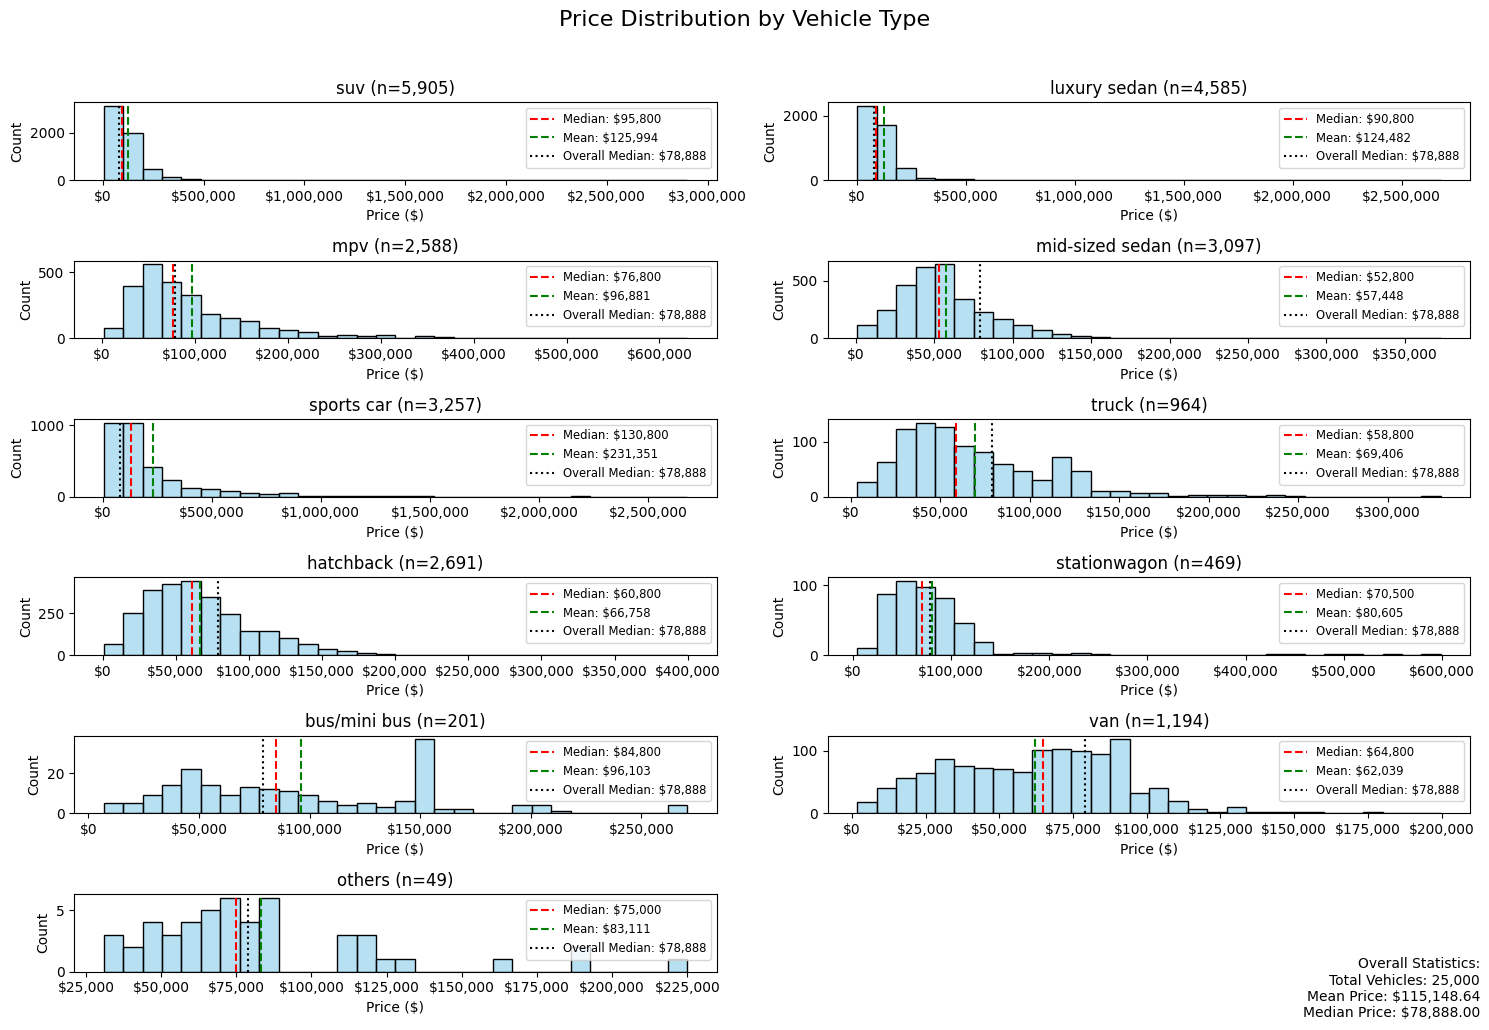


Summary Statistics by Vehicle Type:
--------------------------------------------------------------------------------
                 count         mean       median          std         min  \
type_of_vehicle                                                             
bus/mini bus       201   $96,102.98   $84,800.00   $56,343.52   $6,900.00   
hatchback         2691   $66,757.88   $60,800.00   $36,656.29     $700.00   
luxury sedan      4585  $124,481.51   $90,800.00  $172,499.49   $2,100.00   
mid-sized sedan   3097   $57,448.17   $52,800.00   $32,102.54     $900.00   
mpv               2588   $96,881.00   $76,800.00   $70,073.39   $1,900.00   
others              49   $83,110.63   $75,000.00   $41,073.10  $30,888.00   
sports car        3257  $231,351.24  $130,800.00  $271,566.67   $3,999.00   
stationwagon       469   $80,604.89   $70,500.00   $63,818.85   $4,350.00   
suv               5905  $125,993.52   $95,800.00  $151,206.53   $3,800.00   
truck              964   $69,406.40

In [11]:
def plot_vehicle_type_price_distributions(df, figsize=(15, 10)):
    # Get unique vehicle types
    vehicle_types = df['type_of_vehicle'].unique()
    n_types = len(vehicle_types)
    
    # Calculate number of rows and columns for subplots
    n_cols = 2
    n_rows = (n_types + 1) // 2  # Ceiling division
    
    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Price Distribution by Vehicle Type', fontsize=16, y=1.02)
    
    # Flatten axes array for easier iteration
    axes = axes.flatten()
    
    # Calculate general statistics for price
    overall_median = df['price'].median()
    overall_mean = df['price'].mean()
    
    # Create histograms for each vehicle type
    for idx, v_type in enumerate(vehicle_types):
        ax = axes[idx]
        
        # Get data for this vehicle type
        type_data = df[df['type_of_vehicle'] == v_type]['price']
        
        # Create histogram
        sns.histplot(data=type_data, bins=30, ax=ax, color='skyblue', alpha=0.6)
        
        # Add vertical lines for mean and median
        type_median = type_data.median()
        type_mean = type_data.mean()
        
        ax.axvline(type_median, color='red', linestyle='--', label=f'Median: ${type_median:,.0f}')
        ax.axvline(type_mean, color='green', linestyle='--', label=f'Mean: ${type_mean:,.0f}')
        ax.axvline(overall_median, color='black', linestyle=':', label=f'Overall Median: ${overall_median:,.0f}')
        
        # Customize plot
        ax.set_title(f'{v_type} (n={len(type_data):,})')
        ax.set_xlabel('Price ($)')
        ax.set_ylabel('Count')
        
        # Format x-axis with dollar amounts
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        # Add legend
        ax.legend(fontsize='small')
        
    # Remove any empty subplots
    for idx in range(len(vehicle_types), len(axes)):
        fig.delaxes(axes[idx])
    
    # Add overall statistics text box
    fig.text(0.99, 0.01, 
             f'Overall Statistics:\n'
             f'Total Vehicles: {len(df):,}\n'
             f'Mean Price: ${overall_mean:,.2f}\n'
             f'Median Price: ${overall_median:,.2f}',
             fontsize=10,
             horizontalalignment='right',
             verticalalignment='bottom',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics by Vehicle Type:")
    print("-" * 80)
    summary_stats = df.groupby('type_of_vehicle')['price'].agg([
        ('count', 'count'),
        ('mean', 'mean'),
        ('median', 'median'),
        ('std', 'std'),
        ('min', 'min'),
        ('max', 'max')
    ]).round(2)
    
    # Format currency columns
    for col in ['mean', 'median', 'std', 'min', 'max']:
        summary_stats[col] = summary_stats[col].apply(lambda x: f"${x:,.2f}")
    
    print(summary_stats)
    
    return summary_stats

stats = plot_vehicle_type_price_distributions(train_df)

Check price variance by make

Plot price

count    2.500000e+04
mean     1.151486e+05
std      1.555725e+05
min      7.000000e+02
25%      4.914100e+04
50%      7.888800e+04
75%      1.258000e+05
max      2.899999e+06
Name: price, dtype: float64


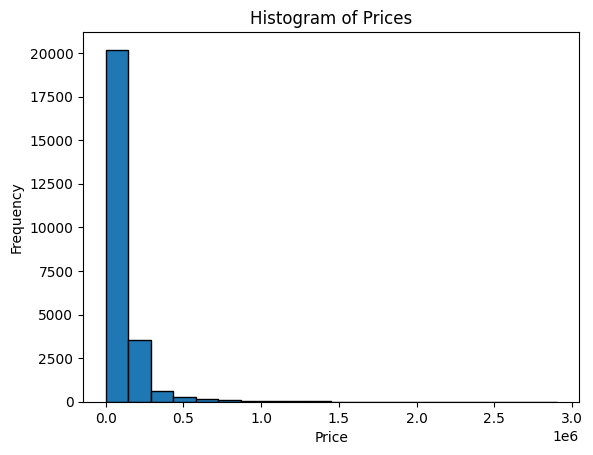

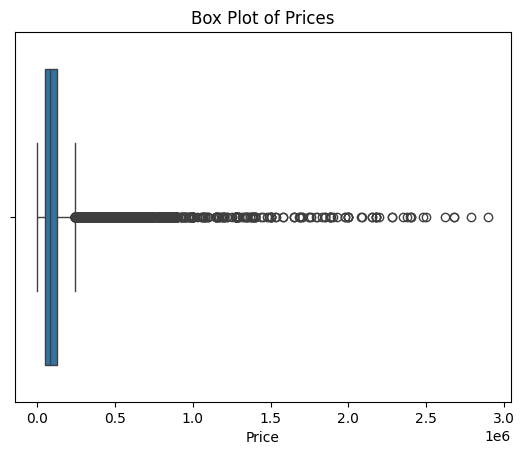

C:\Users\Roheth Bala\AppData\Local\Temp\ipykernel_209140\512305420.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['price'], shade=True)


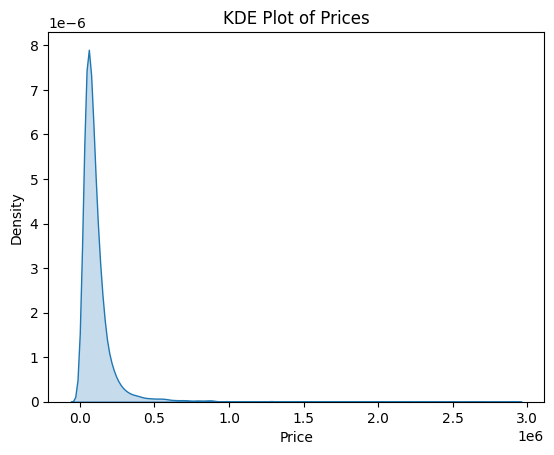

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame 'df' with a 'price' column
df = train_df
# Descriptive statistics
print(df['price'].describe())

# Histogram
plt.hist(df['price'], bins=20, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Prices')
plt.show()

# Box plot
sns.boxplot(x=df['price'])
plt.xlabel('Price')
plt.title('Box Plot of Prices')
plt.show()

# KDE plot
sns.kdeplot(df['price'], shade=True)
plt.xlabel('Price')
plt.title('KDE Plot of Prices')
plt.show()

In [13]:
price_variance = train_df.groupby('make')['price'].var()
print(price_variance)

make
aion                     NaN
alfa romeo      9.813151e+09
alpine          2.026692e+09
aston martin    3.319222e+10
audi            7.031976e+09
                    ...     
ud              2.449221e+09
valiant                  NaN
volkswagen      1.777395e+09
volvo           3.609490e+09
yutong          1.418022e+09
Name: price, Length: 95, dtype: float64


### find how depreciation correlates with depreciation

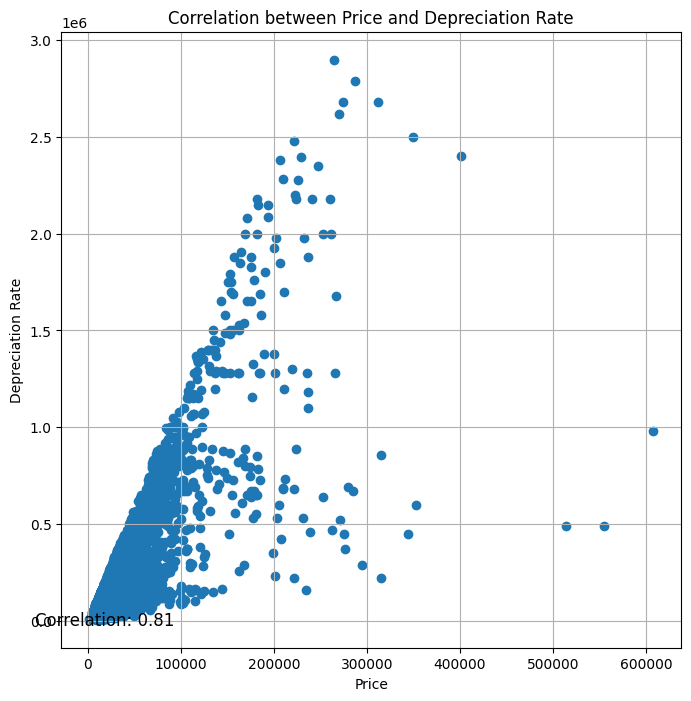

Correlation between price and depreciation rate: 0.8118056032938004


In [14]:
correlation = train_df['depreciation'].corr(train_df['price'])

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(train_df['depreciation'], train_df['price'])
plt.xlabel('Price')
plt.ylabel('Depreciation Rate')
plt.title('Correlation between Price and Depreciation Rate')
plt.text(18000, 0.17, f"Correlation: {correlation:.2f}", ha='center', va='center', fontsize=12)
plt.grid(True)
plt.show()

print("Correlation between price and depreciation rate:", correlation)

Plot transmission_type to price

C:\Users\Roheth Bala\AppData\Local\Temp\ipykernel_209140\3853897905.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=train_df, x='transmission', y='price', jitter=True, palette='viridis')


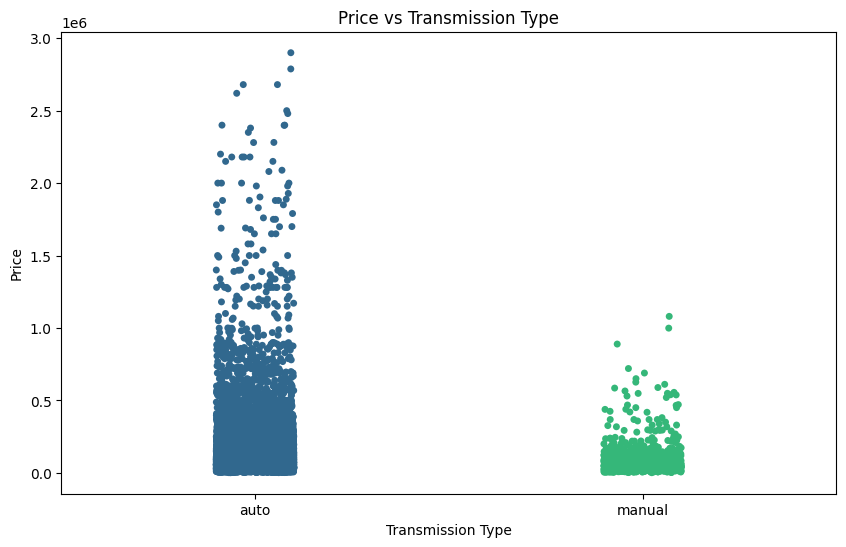

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert transmission_type to a categorical type for plotting
plt.figure(figsize=(10, 6))
sns.stripplot(data=train_df, x='transmission', y='price', jitter=True, palette='viridis')
plt.title('Price vs Transmission Type')
plt.xlabel('Transmission Type')
plt.ylabel('Price')
plt.show()

# Fill missing attributes

1. Fill manufactured year from original registration date

In [16]:
def fill_manufactured_year(df):
    # Convert 'reg_date' to datetime, coerce errors to NaT for unparseable dates
    df['original_reg_date'] = pd.to_datetime(df['original_reg_date'], errors='coerce', infer_datetime_format=True)
    
    # Extract the year from 'reg_date' and fill it in 'manufactured' where missing
    df['manufactured'] = df['original_reg_date'].dt.year.fillna(df['manufactured'])
    
    return df
    
train_df = fill_manufactured_year(train_df)
test_df = fill_manufactured_year(test_df)

C:\Users\Roheth Bala\AppData\Local\Temp\ipykernel_209140\3985682950.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['original_reg_date'] = pd.to_datetime(df['original_reg_date'], errors='coerce', infer_datetime_format=True)
C:\Users\Roheth Bala\AppData\Local\Temp\ipykernel_209140\3985682950.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['original_reg_date'] = pd.to_datetime(df['original_reg_date'], errors='coerce', infer_datetime_format=True)
C:\Users\Roheth Bala\AppData\Local\Temp\ipykernel_209140\3985682950.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. 

Test train split

In [17]:
X= train_df
y = train_df['price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

## Data preprocessing
### Fill missing values and derive numerical features from categorical attributes

Fill missing make from model

In [18]:
model_to_make_map = {}
# fill make using the model
def fillMissingMakeFromModelFit(train_df):
    train_df['make'] = train_df['make'].replace('nan', '')
    model_to_make_map = train_df.groupby('model')['make'].first().to_dict()
    return model_to_make_map
def fillMissingMakeFromModelTransform(train_df):
    train_df['make'] = train_df['model'].map(model_to_make_map).fillna(train_df['make'])
model_to_make_map=fillMissingMakeFromModelFit(X_train)  
fillMissingMakeFromModelTransform(X_train)
fillMissingMakeFromModelTransform(X_valid)
fillMissingMakeFromModelTransform(test_df)
    #missing_columns(train_df,categorical_columns)

Label encode vehicle type

In [19]:
print_numerical_missing(X_train)
print_numerical_missing(X_valid)


Missing Percentages for Numerical Columns:
--------------------------------------------------
manufactured                   0.03%
curb_weight                    1.21%
power                          10.54%
engine_cap                     2.38%
no_of_owners                   0.06%
depreciation                   2.00%
coe                            0.00%
road_tax                       10.49%
dereg_value                    0.92%
mileage                        21.24%
omv                            0.24%
arf                            0.70%
price                          0.00%

Missing Percentages for Numerical Columns:
--------------------------------------------------
manufactured                   0.00%
curb_weight                    1.32%
power                          10.62%
engine_cap                     2.42%
no_of_owners                   0.14%
depreciation                   2.14%
coe                            0.00%
road_tax                       10.68%
dereg_value                 

{'manufactured': np.float64(0.0),
 'curb_weight': np.float64(1.32),
 'power': np.float64(10.620000000000001),
 'engine_cap': np.float64(2.42),
 'no_of_owners': np.float64(0.13999999999999999),
 'depreciation': np.float64(2.1399999999999997),
 'coe': np.float64(0.0),
 'road_tax': np.float64(10.68),
 'dereg_value': np.float64(0.7000000000000001),
 'mileage': np.float64(21.12),
 'omv': np.float64(0.3),
 'arf': np.float64(0.66),
 'price': np.float64(0.0)}

Fill missing power, curb_weight from title
Then fill missing power, road_tax from engine_cap

In [20]:
title_to_power_weight_map={}
engine_cap_to_power_road_tax_map={}
def titlePowerWeightFit(df):
    # Create a mapping from title to mode power and curb_weight
    title_to_power_weight_map = df.groupby('title')[['power', 'curb_weight']].agg(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict('index')
    return title_to_power_weight_map
def engineCapPowerRTFit(df):
    engine_cap_to_power_road_tax_map = df.groupby('engine_cap')[['power', 'road_tax']].agg(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict('index')
    return engine_cap_to_power_road_tax_map
# Function to fill missing values
def fill_missing_values_by_title(row):
    title = row['title']
    if pd.isnull(row['power']) or pd.isnull(row['curb_weight']):
        if title in title_to_power_weight_map:
            power_mode = title_to_power_weight_map[title]['power']
            curb_weight_mode = title_to_power_weight_map[title]['curb_weight']
            return power_mode, curb_weight_mode
    return row['power'], row['curb_weight']

def fill_missing_values_by_engine_cap(row):
    engine_cap = row['engine_cap']
    if pd.isnull(row['power']):
        if engine_cap in engine_cap_to_power_road_tax_map:
            power_mode = engine_cap_to_power_road_tax_map[engine_cap]['power']
            #road_tax_mode = engine_cap_to_power_road_tax_map[engine_cap]['road_tax']
            return power_mode#, road_tax_mode
    return row['power']#, row['road_tax']
def titlePowerWeightTransform(df):
    df[['power', 'curb_weight']] = df.apply(fill_missing_values_by_title, axis=1, result_type='expand')
    return df

def engineCapPowerRTTransform(df):
    df['power'] = df.apply(fill_missing_values_by_engine_cap, axis=1)
    return df

title_to_power_weight_map=titlePowerWeightFit(X_train)
engine_cap_to_power_road_tax_map=engineCapPowerRTFit(X_train)
X_train=titlePowerWeightTransform(X_train)
X_train=engineCapPowerRTTransform(X_train)
titlePowerWeightTransform(X_valid)
engineCapPowerRTTransform(X_valid)
titlePowerWeightTransform(test_df)
engineCapPowerRTTransform(test_df)

,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,transmission,...,coe,road_tax,dereg_value,mileage,omv,arf,opc_scheme,lifespan,features,accessories
0,honda vezel 1.5a x,honda,vezel,4614,2015.0,NaT,29-apr-2015,suv,parf car,auto,...,57199,682.0,9582.0,112000.0,19229.0,9229.0,NaN,NaN,"powerful 1.5l i-vtec engine producing 128bhp, ...","pioneer touch screen with reverse camera, 16"" ..."
1,mazda 3 1.6a sp (coe till 10/2027),mazda,3,extremely well maintained and in pristine cond...,2007.0,NaT,26-oct-2007,mid-sized sedan,"coe car, premium ad car, low mileage car",auto,...,42564,1113.0,13644.0,120000.0,14347.0,15782.0,NaN,NaN,fuel efficient 1.6l 4-cylinder inline 16-valve...,"multi-function steering wheel, keyless entry, ..."
2,mini cooper s countryman 2.0a,mini,cooper,1 owner! beautiful island blue color! eurokars...,2019.0,NaT,27-mar-2020,sports car,parf car,auto,...,32801,1210.0,54818.0,43000.0,39863.0,47809.0,NaN,NaN,"output of 141kw, 189bhp at 5000rpm to 6000rpm,...","18"" sports rims, sports leather seats, navigat..."
3,toyota vios 1.5a g,toyota,vios,fully agent maintain! genuine low mileage at 5...,2019.0,NaT,28-jun-2019,mid-sized sedan,"parf car, premium ad car",auto,...,29159,682.0,26363.0,53300.0,15573.0,15573.0,NaN,NaN,"1.5l 4 cylinder 16 valves dohc vvt-i engine, 7...","push start button, toyota factory player, reve..."
4,mazda 3 hb 1.5a,mazda,3,workshop check/sta evaluation available. accid...,2015.0,NaT,19-nov-2015,hatchback,"parf car, premium ad car",auto,...,56001,682.0,15197.0,149000.0,18097.0,13097.0,NaN,NaN,1.5l 4 cylinder inline dohc 16 valves skyactiv...,factory fitted audio with audio & multi functi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,mg hs 1.5a turbo,mg,hs,stylish and fuel-efficient drive at an afford...,2020.0,NaT,30-nov-2020,suv,parf car,auto,...,41503,680.0,40705.0,50000.0,19388.0,19388.0,NaN,NaN,powered by a 1.5l turbocharged inline-4 cylind...,"17-inch rims, led drls, 10"" color touch screen..."
9996,mercedes-benz gla-class gla180 progressive,mercedes-benz,gla180,1 owner and low mileage. comes with agent warr...,2022.0,NaT,21-feb-2023,suv,"parf car, premium ad car, low mileage car",auto,...,86000,586.0,104529.0,8500.0,34087.0,39722.0,NaN,NaN,powered by a inline 4 cylinder turbocharged en...,"factory 10.25"" mbux infotainment system with a..."
9997,bmw 3 series 320i convertible (coe till 09/2030),bmw,320,"just install koni shocks, for the best road ha...",2010.0,NaT,17-dec-2010,sports car,coe car,auto,...,34935,1691.0,22004.0,163955.0,42233.0,42233.0,NaN,NaN,"2.0l engine, rare convertible. view specs of t...","new upgraded steering, android player, flawles..."
9998,kia cerato 1.6a ex,kia,cerato,"at dickson, we don't just sell cars, we sell t...",2019.0,NaT,02-mar-2020,mid-sized sedan,parf car,auto,...,30010,738.0,28242.0,85473.0,14799.0,14799.0,NaN,NaN,responsive 1.6l 4 cylinders inline 16 valve du...,"3 day money-back, certified cars, one-year war..."


## FIll missing engine_cap from:
    1. Power and type_of_vehicle
    2. Title

In [21]:
import pandas as pd

class PowerTypeEngineCapFiller:
    def __init__(self):
        self.power_type_to_engine_cap = {}
    
    def fit(self, df):
        """Create a mapping from (power, type_of_vehicle) to engine_cap using training data."""
        # Filter rows with non-null engine_cap to create the mapping
        mapping_df = df[df['engine_cap'].notna()]
        
        # Create the mapping based on the median engine capacity for each (power, type_of_vehicle) pair
        self.power_type_to_engine_cap = (
            mapping_df.groupby(['power', 'type_of_vehicle'])['engine_cap']
            .median()
            .to_dict()
        )
        return self
    
    def transform(self, df):
        """Fill missing engine_cap values using the power_type_to_engine_cap mapping."""
        
        # Function to fill engine_cap based on the map
        def fill_engine_cap(row):
            if pd.isna(row['engine_cap']):
                return self.power_type_to_engine_cap.get((row['power'], row['type_of_vehicle']))
            return row['engine_cap']
        
        # Apply the fill function to each row
        df['engine_cap'] = df.apply(fill_engine_cap, axis=1)
        return df

# Usage
filler = PowerTypeEngineCapFiller()
filler.fit(X_train)

# Fill missing engine_cap in X_train, X_valid, and test_df
X_train = filler.transform(X_train)
X_valid = filler.transform(X_valid)
test_df = filler.transform(test_df)

import pandas as pd

class TitleEngineCapFiller:
    def __init__(self):
        self.title_to_engine_cap = {}
    
    def fit(self, df):
        """Create a mapping from title to engine_cap using training data."""
        # Filter rows with non-null engine_cap to create the mapping
        mapping_df = df[df['engine_cap'].notna()]
        
        # Create the mapping based on the median engine capacity for each title
        self.title_to_engine_cap = (
            mapping_df.groupby('title')['engine_cap']
            .median()
            .to_dict()
        )
        return self
    
    def transform(self, df):
        """Fill missing engine_cap values using the title_to_engine_cap mapping."""
        
        # Function to fill engine_cap based on the title map
        def fill_engine_cap(row):
            if pd.isna(row['engine_cap']):
                return self.title_to_engine_cap.get(row['title'])
            return row['engine_cap']
        
        # Apply the fill function to each row
        df['engine_cap'] = df.apply(fill_engine_cap, axis=1)
        return df

# Usage
filler = TitleEngineCapFiller()
filler.fit(X_train)

# Fill missing engine_cap in X_train, X_valid, and test_df
X_train = filler.transform(X_train)
X_valid = filler.transform(X_valid)
test_df = filler.transform(test_df)

### Derive age from manufactured
### Derive remaining_months and if the vehicle is heavy or not

In [22]:
from datetime import datetime


def calculate_age(df):
    df['age'] = 2024 - df['manufactured']

def calculate_remaining_months_and_heavy(row):
    count = 0
    if row['type_of_vehicle'] in ['truck', 'van','bus']:
        return 240-12*row['age'],1
    else:
        if row['age'] < 10:
            return 120 - 12*row['age'], 0
        else:
            next_multiple_of_5 = ((row['age'] *12)// 5 + 1) * 5
            return next_multiple_of_5 - 12*row['age'], 0

def calculateRemainingMonths(train_df):
    train_df['remaining_months'], train_df['heavy'] = zip(*train_df.apply(calculate_remaining_months_and_heavy, axis=1))
calculate_age(X_train)
calculate_age(X_valid)
calculate_age(test_df)

X_train = X_train[X_train['age'] > 0]
X_valid = X_valid[X_valid['age'] > 0]


calculateRemainingMonths(X_train)
calculateRemainingMonths(X_valid)
calculateRemainingMonths(test_df)

X_train = X_train[X_train['remaining_months'] >= 0]
X_valid = X_valid[X_valid['remaining_months'] >= 0]

#missing_columns(train_df,numerical_columns)
#missing_columns(test_df,numerical_columns)

### Calculate coe category

In [23]:
def calculate_category(row):
    if row['heavy'] == 1:
        return 1
    elif row['engine_cap'] > 1600:
        return 3
    else:
        return 2
def calcCulateCat(train_df):
    train_df['cat'] = train_df.apply(calculate_category, axis=1)

calcCulateCat(X_train)
calcCulateCat(X_valid)
calcCulateCat(test_df)

### Calculate arf

In [24]:
def calculate_arf(omv):
    if omv <= 20000:
        arf = omv - 5000  # Assuming a fixed VES rebate of 5000
    elif 20000 < omv <= 40000:
        arf = ((omv - 20000) * 1.4 + 20000) - 5000
    elif 40000 < omv <= 60000:
        arf = ((omv - 40000) * 1.9 + 48000) - 5000
    elif 60000 < omv <= 80000:
        arf = ((omv - 60000) * 2.5 + 86000) - 5000
    else:
        arf = ((omv - 80000) * 3.2 + 136000) - 5000

    return arf
def calculateArf(train_df):
    # Calculate ARF for missing values
    train_df['arf'] = train_df['arf'].fillna(train_df['omv'].apply(calculate_arf))


calculateArf(X_train)
calculateArf(X_valid)
calculateArf(test_df)

In [25]:
class VehicleTypeEncoder:
    def __init__(self, encoding_method='label'):
        self.encoding_method = encoding_method
        self.label_encoder = LabelEncoder()
        self.mapping = None
        self.target_means = None  # Stores the target encoding means
        self.target_default = None  # Default mean for unseen categories
    
    def fit(self, X, y=None):
        if self.encoding_method == 'label':
            self.label_encoder.fit(X['type_of_vehicle'])
        
        elif self.encoding_method == 'target':
            if y is None:
                raise ValueError("Target variable 'y' must be provided for target encoding.")
            # Compute mean of target for each category in type_of_vehicle
            self.target_means = X.groupby('type_of_vehicle')[y.name].mean()
            self.target_default = y.mean()  # Default for unseen categories
        
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        
        if self.encoding_method == 'label':
            categories = pd.Series(self.label_encoder.classes_)
            new_categories = ~X['type_of_vehicle'].isin(categories)
            if new_categories.any():
                print(f"Warning: Found new categories in transform: {X['type_of_vehicle'][new_categories].unique()}")
                X_encoded.loc[new_categories, 'type_of_vehicle'] = categories[0]
            
            X_encoded['type_of_vehicle'] = self.label_encoder.transform(X_encoded['type_of_vehicle'])
            
        elif self.encoding_method == 'target':
            # Map each category to its mean target value, with a default for unseen categories
            X_encoded['type_of_vehicle'] = X_encoded['type_of_vehicle'].map(self.target_means).fillna(self.target_default)
        
        return X_encoded
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

# Usage example:
# Initialize encoder with target encoding method
encoder = VehicleTypeEncoder(encoding_method='target')

# Fit and transform training data, providing the target variable y (price)
X_train = encoder.fit_transform(X_train, y=y_train)

# Transform validation and test data using the same encoding (target variable not needed here)
X_valid = encoder.transform(X_valid)
test_df = encoder.transform(test_df)

### calculate mileage from type_of_vehicle(one hot encoded) and age using a regression

In [26]:
'''
import xgboost as xgb
# Instantiate the model and imputer globally
xgb_regressor = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
imputer = SimpleImputer(strategy='mean')

def mileageFit(train_df):
    # Step 1: Prepare the data
    train_df_encoded = pd.get_dummies(train_df, columns=['type_of_vehicle'], drop_first=True)
    
    # Separate rows with known mileage (for fitting the model)
    train_data = train_df_encoded.dropna(subset=['mileage'])
    
    # Step 2: Define features and target variable
    feature_columns = ['age'] + [col for col in train_df_encoded.columns if col.startswith('type_of_vehicle_')]
    
    # Separate features and target
    X_train = train_data[feature_columns]
    y_train = train_data['mileage']
    
    # Step 3: Impute missing values in features
    X_train_imputed = imputer.fit_transform(X_train)
    
    # Fit the XGBoost model
    xgb_regressor.fit(X_train_imputed, y_train, eval_set=[(X_train_imputed, y_train)], verbose=False)
    print("Fit completed on X_train")
    
    # Return the fitted feature columns for consistent use with X_valid
    return feature_columns

def mileageTransform(df, feature_columns):
    # One-hot encode categorical variables in the test data
    df_encoded = pd.get_dummies(df, columns=['type_of_vehicle'], drop_first=True)
    
    # Ensure missing columns in feature_columns are filled with zeros for compatibility
    for col in feature_columns:
        if col not in df_encoded.columns:
            df_encoded[col] = 0

    # Select and impute the feature columns
    X = df_encoded[feature_columns]
    X_imputed = imputer.transform(X)
    
    # Predict mileage for rows with missing values
    missing_data = df_encoded['mileage'].isna()
    if missing_data.any():
        df_encoded.loc[missing_data, 'mileage'] = xgb_regressor.predict(X_imputed[missing_data])

    return df_encoded

# Usage
# Fit only on X_train
feature_columns = mileageFit(X_train)

# Transform both X_train and X_valid without refitting
X_train = mileageTransform(X_train, feature_columns)
X_valid = mileageTransform(X_valid, feature_columns)
test_df= mileageTransform(test_df, feature_columns)
'''
import xgboost as xgb
from sklearn.impute import SimpleImputer
import pandas as pd

# Instantiate the model and imputer globally
xgb_regressor = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
imputer = SimpleImputer(strategy='mean')

def mileageFit(train_df):
    # Step 1: Prepare the data
    # Only use 'age' and 'no_of_owners' columns for features
    feature_columns = ['age', 'no_of_owners']
    
    # Separate rows with known mileage (for fitting the model)
    train_data = train_df.dropna(subset=['mileage'])
    
    # Separate features and target
    X_train = train_data[feature_columns]
    y_train = train_data['mileage']
    
    # Step 2: Impute missing values in features
    X_train_imputed = imputer.fit_transform(X_train)
    
    # Fit the XGBoost model
    xgb_regressor.fit(X_train_imputed, y_train, eval_set=[(X_train_imputed, y_train)], verbose=False)
    print("Fit completed on X_train")
    
    return feature_columns

def mileageTransform(df, feature_columns):
    # Select the feature columns
    X = df[feature_columns]
    
    # Impute missing values
    X_imputed = imputer.transform(X)
    
    # Predict mileage for rows with missing values
    missing_data = df['mileage'].isna()
    if missing_data.any():
        df.loc[missing_data, 'mileage'] = xgb_regressor.predict(X_imputed[missing_data])

    return df

# Usage
# Fit only on X_train
feature_columns = mileageFit(X_train)

# Transform both X_train and X_valid without refitting
X_train = mileageTransform(X_train, feature_columns)
X_valid = mileageTransform(X_valid, feature_columns)
test_df = mileageTransform(test_df, feature_columns)


Fit completed on X_train


### Target encode category

In [27]:


class TargetEncoder(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.encodings_ = {}

    def fit(self, X, y=None):
        for col in self.columns:
            self.encodings_[col] = X.groupby(col)['price'].mean()
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for col in self.columns:
            X_encoded[f"{col}Encoded"] = X_encoded[col].map(self.encodings_[col])
        return X_encoded

In [28]:
target_encoder = TargetEncoder(columns=['category'])
X_train = target_encoder.fit_transform(X_train)
X_valid = target_encoder.transform(X_valid)
test_df = target_encoder.transform(test_df)

### Ordinal encode Parf or COE using categories
### Ordinal code(this is equivalent to one-hot encode in this case) transmission_type

PROCESSING CATEGORY COLUMN

Processing category...

pOrC distribution:

Counts:
pOrC
P    15088
C     4769
Name: count, dtype: int64

Percentages:
pOrC
P    76.0%
C    24.0%
Name: proportion, dtype: object

pOrC-Price Statistics:
--------------------------------------------------
           mean   median        std  count
pOrC                                      
C      93967.79  69800.0   97248.38   4769
P     121934.75  81994.0  173306.83  15088


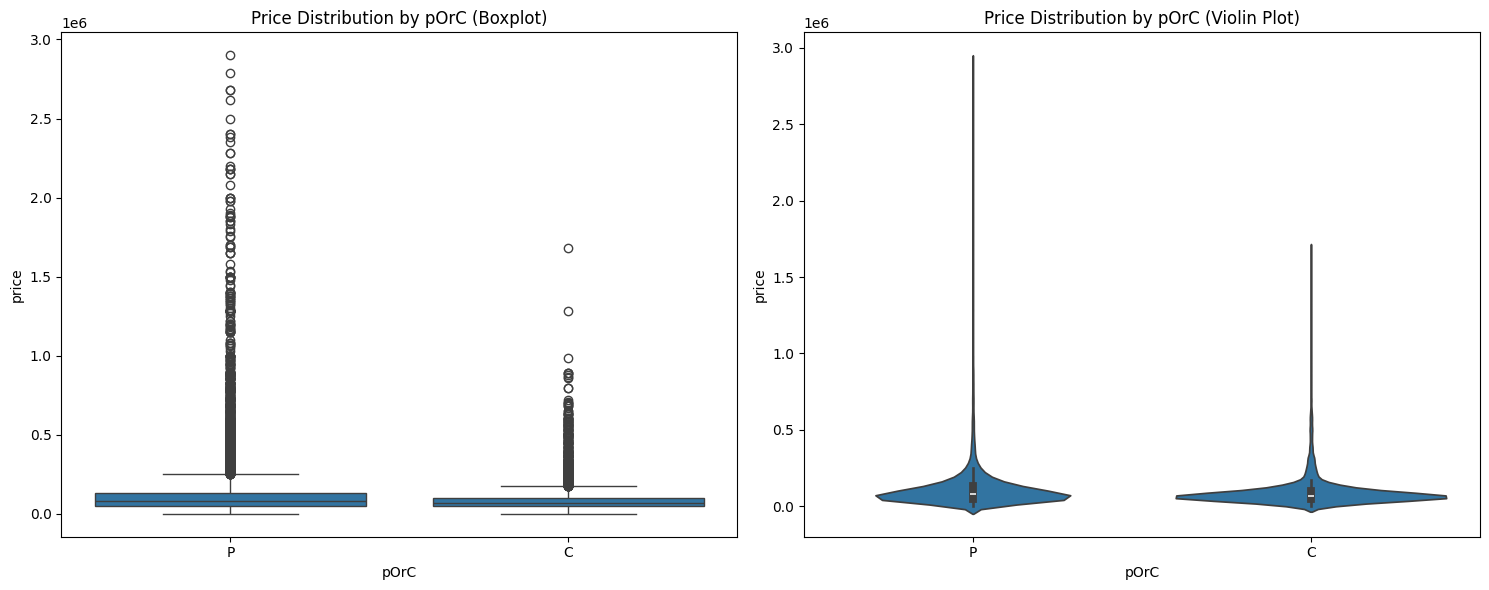


Testing possible orderings for pOrC:
--------------------------------------------------
Ordering P: 0, C: 1, N: 2
Correlation: -0.0752

Ordering P: 0, C: 2, N: 1
Correlation: -0.0752

Ordering P: 1, C: 0, N: 2
Correlation: 0.0752

Ordering P: 1, C: 2, N: 0
Correlation: -0.0752

Ordering P: 2, C: 0, N: 1
Correlation: 0.0752

Ordering P: 2, C: 1, N: 0
Correlation: 0.0752


All orderings ranked by correlation strength for pOrC:
--------------------------------------------------
Rank 1:
Ordering: P: 0, C: 1, N: 2
Correlation: -0.0752

Rank 2:
Ordering: P: 0, C: 2, N: 1
Correlation: -0.0752

Rank 3:
Ordering: P: 1, C: 0, N: 2
Correlation: 0.0752

Rank 4:
Ordering: P: 1, C: 2, N: 0
Correlation: -0.0752

Rank 5:
Ordering: P: 2, C: 0, N: 1
Correlation: 0.0752

Rank 6:
Ordering: P: 2, C: 1, N: 0
Correlation: 0.0752


PROCESSING TRANSMISSION COLUMN

Processing transmission...

transmission_type distribution:

Counts:
transmission_type
A    18534
M     1323
Name: count, dtype: int64

Percentages

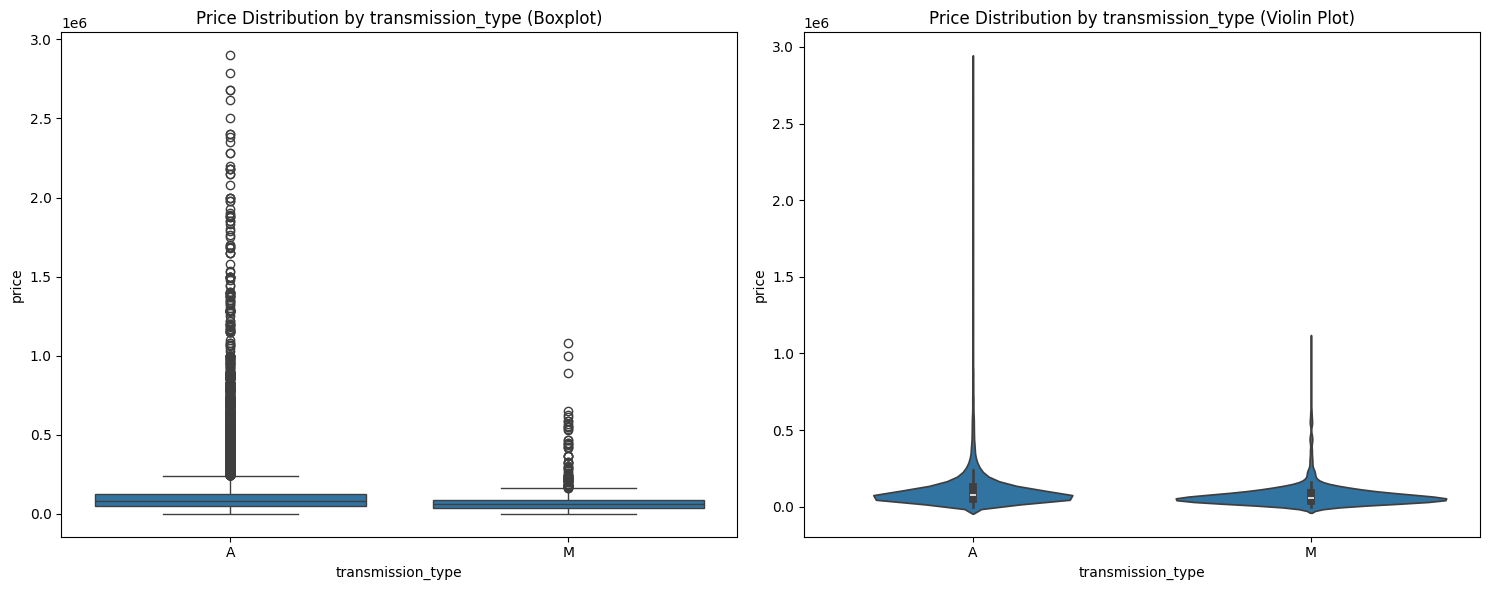


Testing possible orderings for transmission_type:
--------------------------------------------------
Ordering A: 0, M: 1
Correlation: -0.0623

Ordering A: 1, M: 0
Correlation: 0.0623


All orderings ranked by correlation strength for transmission_type:
--------------------------------------------------
Rank 1:
Ordering: A: 0, M: 1
Correlation: -0.0623

Rank 2:
Ordering: A: 1, M: 0
Correlation: 0.0623


Processing category...

Processing transmission...

Processing category...

Processing transmission...


In [29]:


class CategoryEncoder:
    def __init__(self):
        self.pOrC_ordering = None
        self.transmission_ordering = None
        
    def extract_p_or_c(self, category_string):
        """Extract 'P' for PARF, 'C' for COE, 'N' for None from category string"""
        if pd.isna(category_string):
            return 'N'
        
        categories = str(category_string).lower().split(',')
        categories = [cat.strip() for cat in categories]
        if 'parf car' in categories:
            return 'P'
        elif 'coe car' in categories:
            return 'C'
        else:
            return 'N'

    def extract_transmission_type(self, transmission_string):
        """Extract 'A' for Auto, 'M' for Manual from transmission string"""
        if pd.isna(transmission_string):
            return 'N'
        
        trans_type = str(transmission_string).lower().strip()
        if 'auto' in trans_type:
            return 'A'
        elif 'manual' in trans_type:
            return 'M'
        else:
            return 'N'

    def evaluate_ordering(self, df, column, ordering_dict, target_col='price'):
        """Evaluate correlation between encoded categories and target"""
        encoded_values = pd.to_numeric(df[column].map(ordering_dict), errors='coerce')
        valid_mask = ~(encoded_values.isna() | df[target_col].isna())
        
        if valid_mask.sum() == 0:
            return 0
        
        correlation = encoded_values[valid_mask].corr(df[target_col][valid_mask])
        return correlation

    def find_optimal_ordering(self, df, column, categories, target_col='price'):
        """Find optimal ordering of categories by testing all permutations"""
        all_permutations = list(permutations(range(len(categories))))
        results = []
        
        print(f"\nTesting possible orderings for {column}:")
        print("-" * 50)
        
        for perm in all_permutations:
            ordering_dict = {cat: val for cat, val in zip(categories, perm)}
            corr = self.evaluate_ordering(df, column, ordering_dict, target_col)
            
            order_str = ", ".join([f"{k}: {v}" for k, v in ordering_dict.items()])
            print(f"Ordering {order_str}")
            print(f"Correlation: {corr:.4f}")
            print()
            
            results.append({
                'ordering': ordering_dict,
                'correlation': corr,
                'permutation': perm
            })
        
        results.sort(key=lambda x: abs(x['correlation']), reverse=True)
        return results

    def analyze_price_relationship(self, df, column, target_col='price'):
        """Analyze relationship between categories and price"""
        stats = df.groupby(column)[target_col].agg(['mean', 'median', 'std', 'count']).round(2)
        
        print(f"\n{column}-Price Statistics:")
        print("-" * 50)
        print(stats)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        sns.boxplot(x=column, y=target_col, data=df, ax=ax1)
        ax1.set_title(f'Price Distribution by {column} (Boxplot)')
        
        sns.violinplot(x=column, y=target_col, data=df, ax=ax2)
        ax2.set_title(f'Price Distribution by {column} (Violin Plot)')
        
        plt.tight_layout()
        plt.show()
        
        return stats

    def process_column(self, df, column_name, extracted_column_name, categories, extract_func, target_col='price', fit=True):
        """Process a single column through the analysis pipeline"""
        print(f"\nProcessing {column_name}...")
        
        # Step 1: Extract categories
        df[extracted_column_name] = df[column_name].apply(extract_func)
        if extracted_column_name == "pOrC":
            df['pOrC'] = df.apply(lambda x: 'P' if x['pOrC'] == 'N' and x['age'] < 120 else x['pOrC'], axis=1)
            
        if fit:
            # Step 2: Get distribution
            print(f"\n{extracted_column_name} distribution:")
            counts = df[extracted_column_name].value_counts()
            percentages = df[extracted_column_name].value_counts(normalize=True).round(3) * 100
            print("\nCounts:")
            print(counts)
            print("\nPercentages:")
            print(percentages.astype(str) + '%')
            
            # Step 3: Analyze relationship with price
            stats = self.analyze_price_relationship(df, extracted_column_name, target_col)
            
            # Step 4: Find optimal ordering
            ordering_results = self.find_optimal_ordering(df, extracted_column_name, categories, target_col)
            
            # Step 5: Print results
            print(f"\nAll orderings ranked by correlation strength for {extracted_column_name}:")
            print("-" * 50)
            for i, result in enumerate(ordering_results, 1):
                order_str = ", ".join([f"{k}: {v}" for k, v in result['ordering'].items()])
                print(f"Rank {i}:")
                print(f"Ordering: {order_str}")
                print(f"Correlation: {result['correlation']:.4f}")
                print()
            
            # Store best ordering
            best_ordering = ordering_results[0]['ordering']
            if extracted_column_name == 'pOrC':
                self.pOrC_ordering = best_ordering
            else:
                self.transmission_ordering = best_ordering
                
            return df, ordering_results, stats
        
        return df, None, None

    def fit_transform(self, train_df, target_col='price'):
        """Fit on training data and transform it"""
        results = {}
        
        # Process category column
        print("=" * 80)
        print("PROCESSING CATEGORY COLUMN")
        print("=" * 80)
        
        train_df, category_results, category_stats = self.process_column(
            train_df,
            column_name='category',
            extracted_column_name='pOrC',
            categories=['P', 'C', 'N'],
            extract_func=self.extract_p_or_c,
            target_col=target_col,
            fit=True
        )
        
        results['category'] = {
            'results': category_results,
            'stats': category_stats
        }
        
        # Process transmission column
        print("\n" + "=" * 80)
        print("PROCESSING TRANSMISSION COLUMN")
        print("=" * 80)
        
        train_df, transmission_results, transmission_stats = self.process_column(
            train_df,
            column_name='transmission',
            extracted_column_name='transmission_type',
            categories=['A', 'M'],
            extract_func=self.extract_transmission_type,
            target_col=target_col,
            fit=True
        )
        
        results['transmission'] = {
            'results': transmission_results,
            'stats': transmission_stats
        }
        
        # Apply encodings
        train_df['pOrC_encoded'] = train_df['pOrC'].map(self.pOrC_ordering)
        train_df['transmission_type_encoded'] = train_df['transmission_type'].map(self.transmission_ordering)
        
        return train_df, results

    def transform(self, df):
        """Transform new data using fitted encodings"""
        if self.pOrC_ordering is None or self.transmission_ordering is None:
            raise ValueError("Encoder must be fitted before transform can be called")
            
        # Extract categories
        df, _, _ = self.process_column(
            df,
            column_name='category',
            extracted_column_name='pOrC',
            categories=['P', 'C', 'N'],
            extract_func=self.extract_p_or_c,
            fit=False
        )
        
        df, _, _ = self.process_column(
            df,
            column_name='transmission',
            extracted_column_name='transmission_type',
            categories=['A', 'M'],
            extract_func=self.extract_transmission_type,
            fit=False
        )
        
        # Apply encodings
        df['pOrC_encoded'] = df['pOrC'].map(self.pOrC_ordering)
        df['transmission_type_encoded'] = df['transmission_type'].map(self.transmission_ordering)
        
        return df

# Usage example:
def process_categories(X_train, X_valid, test_df):
    # Initialize encoder
    encoder = CategoryEncoder()
    
    # Fit and transform training data
    X_train_encoded, results = encoder.fit_transform(X_train)
    
    # Transform validation and test data
    X_valid_encoded = encoder.transform(X_valid)
    test_df_encoded = encoder.transform(test_df)
    
    return X_train_encoded, X_valid_encoded, test_df_encoded, results

X_train, X_valid, test_df, results = process_categories(X_train, X_valid, test_df)

In [30]:
'''
# Assuming 'df' is your DataFrame
# Extract the year from the 'reg_date' column
train_df['reg_date'] = pd.to_datetime(train_df['reg_date'], infer_datetime_format=True)
train_df['reg_year'] = train_df['reg_date'].dt.year

# Fill 'opc' with 'ROPC' for registrations after 2010
train_df.loc[train_df['reg_year'] >= 2010, 'opc_scheme'] = 'ROPC'
unique_opc_values = train_df['opc_scheme'].unique()
print(unique_opc_values)
'''

"\n# Assuming 'df' is your DataFrame\n# Extract the year from the 'reg_date' column\ntrain_df['reg_date'] = pd.to_datetime(train_df['reg_date'], infer_datetime_format=True)\ntrain_df['reg_year'] = train_df['reg_date'].dt.year\n\n# Fill 'opc' with 'ROPC' for registrations after 2010\ntrain_df.loc[train_df['reg_year'] >= 2010, 'opc_scheme'] = 'ROPC'\nunique_opc_values = train_df['opc_scheme'].unique()\nprint(unique_opc_values)\n"

### Calculate deregistration value and depreciation from omv and arf
### Calculate road_tax from manufactured year, engine_cap and opc_scheme

In [31]:
'''

# Define function to calculate dereg_value and depreciation if they are null
def calculate_dereg_and_depreciation(df):
    # Fill dereg_value if it is null
    df['dereg_value'] = df.apply(
        lambda row: row['omv'] + row['arf'] if pd.isnull(row['dereg_value']) else row['dereg_value'], 
        axis=1
    )

    # Calculate Depreciation Value if it is null
    # Assuming a car lifespan of 10 years in Singapore
    df['depreciation'] = df.apply(
        lambda row: row['dereg_value'] / (10 - row['age']) if pd.isnull(row['depreciation']) and row['age'] < 10 else row['depreciation'], 
        axis=1
    )

    return df

# Apply the function to X_valid, X_train, and test_df
X_valid = calculate_dereg_and_depreciation(X_valid)
X_train = calculate_dereg_and_depreciation(X_train)
test_df = calculate_dereg_and_depreciation(test_df)

'''
import pandas as pd

def calculate_dereg_and_depreciation(df, current_year=2024):
    # Calculate car age
    df['car_age'] = current_year - df['manufactured']
    
    # Fill dereg_value if it is null
    df['dereg_value'] = df.apply(
        lambda row: row['omv'] + row['arf'] if pd.isnull(row['dereg_value']) else row['dereg_value'], 
        axis=1
    )
    
    # Calculate COE rebate based on remaining months (assuming original COE tenure is 10 years)
    df['remaining_coe_years'] = df['remaining_months'] / 12
    df['coe_rebate'] = df.apply(lambda row: max(0, row['coe'] * (row['remaining_coe_years'] / 10)), axis=1)
    
    # Function to calculate PARF rebate based on car age
    def calculate_parf_rebate(car_age, arf):
        if 5 <= car_age < 6:
            return 0.75 * arf
        elif 6 <= car_age < 7:
            return 0.70 * arf
        elif 7 <= car_age < 8:
            return 0.65 * arf
        elif 8 <= car_age < 9:
            return 0.60 * arf
        elif 9 <= car_age <= 10:
            return 0.55 * arf
        else:
            return 0  # No PARF rebate if car age > 10
    
    # Apply PARF rebate calculation
    df['parf_rebate'] = df.apply(lambda row: calculate_parf_rebate(row['car_age'], row['arf']), axis=1)

    df['dereg_value'] = df['coe_rebate'] + df['parf_rebate']
    
    # Calculate Depreciation Value if it is null (Assuming car lifespan is 10 years in Singapore)
    df['depreciation'] = df.apply(
        lambda row: row['dereg_value'] / (10 - row['car_age']) if pd.isnull(row['depreciation']) and row['car_age'] < 10 else row['depreciation'], 
        axis=1
    )
    
    return df

# Apply the function to X_valid, X_train, and test_df
X_valid = calculate_dereg_and_depreciation(X_valid)
X_train = calculate_dereg_and_depreciation(X_train)
test_df = calculate_dereg_and_depreciation(test_df)

class RoadTaxCalculator(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tax_brackets = [
            (600, 200, 0.1750),
            (1000, 300, 0.0375),
            (1600, 400, 0.0750),
            (2000, 600, 0.1250),
            (2500, 800, 0.1750),
            (3000, 1200, 0.2000),
            (float('inf'), 1600, 0.2500)
        ]
        self.fitted = False
    
    def calculate_base_tax(self, engine_cc):
        if pd.isnull(engine_cc):
            return np.nan
        prev_cap = 0
        total_tax = 0
        
        for cap, base, rate in self.tax_brackets:
            if engine_cc <= prev_cap:
                break
            taxable_cc = min(engine_cc, cap) - prev_cap
            total_tax += base + (taxable_cc * rate)
            prev_cap = cap
            if engine_cc <= cap:
                break
                
        return total_tax
    
    def apply_surcharge(self, base_tax, age):
        if pd.isnull(base_tax) or pd.isnull(age):
            return np.nan
        if age <= 10:
            return base_tax
        elif age <= 14:
            return base_tax * 1.1
        else:
            return base_tax * 1.2
    
    def fit(self, X, y=None):
        required_cols = ['engine_cap', 'manufactured', 'opc_scheme']
        missing_cols = [col for col in required_cols if col not in X.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
        self.fitted = True
        return self
    
    def transform(self, X):
        if not self.fitted:
            raise ValueError("Call fit first.")
            
        X = X.copy()
        current_year = pd.Timestamp.now().year
        mask = pd.isnull(X['road_tax'])
        
        if mask.any():
            # Skip rows where essential values are null
            valid_rows = mask & X[['engine_cap', 'manufactured']].notnull().all(axis=1)
            ages = current_year - X.loc[valid_rows, 'manufactured']
            
            # Calculate base tax for valid rows
            base_taxes = X.loc[valid_rows, 'engine_cap'].apply(self.calculate_base_tax)
            
            # Apply surcharge for valid rows
            final_taxes = pd.Series(index=valid_rows[valid_rows].index)
            for idx in final_taxes.index:
                base_tax = base_taxes[idx]
                age = ages[idx]
                final_taxes[idx] = self.apply_surcharge(base_tax, age)
            
            # Apply OPC discount if applicable, filling NaNs with False
            opc_mask = X.loc[valid_rows, 'opc_scheme'].fillna(False)
            final_taxes[opc_mask] *= 0.5
            
            # Convert to annual tax
            final_taxes *= 2
            
            X.loc[valid_rows, 'road_tax'] = final_taxes
        
        return X





# Usage example:
calculator = RoadTaxCalculator()

# Fit and transform training data
X_train = calculator.fit_transform(X_train)

# Transform validation and test data using fitted calculator
X_valid = calculator.transform(X_valid)
test_df = calculator.transform(test_df)


C:\Users\Roheth Bala\AppData\Local\Temp\ipykernel_209140\3825155388.py:147: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  opc_mask = X.loc[valid_rows, 'opc_scheme'].fillna(False)
C:\Users\Roheth Bala\AppData\Local\Temp\ipykernel_209140\3825155388.py:147: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  opc_mask = X.loc[valid_rows, 'opc_scheme'].fillna(False)
C:\Users\Roheth Bala\AppData\Local\Temp\ipykernel_209140\3825155388.py:147: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. C

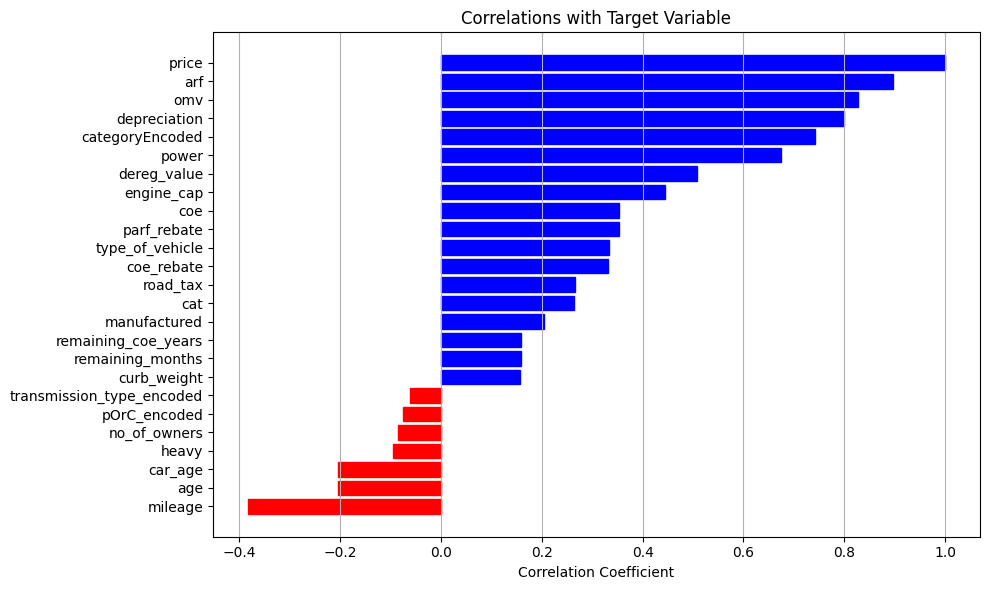

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlations(X, y):
    # Select only numeric columns
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    X_numeric = X[numeric_cols]
    
    # Add target to the dataframe
    data = X_numeric.copy()
    data['target'] = y
    
    # Calculate and sort correlations with target
    correlations = data.corr()['target'].sort_values(ascending=True)
    correlations = correlations.drop('target')
    
    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(correlations.index, correlations.values)
    
    # Color bars based on correlation value
    for bar in bars:
        if bar.get_width() < 0:
            bar.set_color('red')
        else:
            bar.set_color('blue')
    
    plt.title('Correlations with Target Variable')
    plt.xlabel('Correlation Coefficient')
    plt.grid(True, axis='x')
    plt.tight_layout()

# Use the function
plot_correlations(X_train, y_train)
plt.show()

### Drop rows with null values as at this point, we have filled everything we can.

In [33]:

# Drop rows with any remaining null values in specified columns
X_valid = X_valid.dropna(subset=['curb_weight', 'power', 'engine_cap', 'depreciation', 'dereg_value', 'omv','road_tax','arf'])
X_train = X_train.dropna(subset=['curb_weight', 'power', 'engine_cap', 'depreciation', 'dereg_value', 'omv','road_tax','arf'])
y_train = y_train[X_train.index]
y_valid = y_valid[X_valid.index]
print_numerical_missing(X_valid)
print_numerical_missing(X_train)


Missing Percentages for Numerical Columns:
--------------------------------------------------
manufactured                   0.00%
type_of_vehicle                0.00%
curb_weight                    0.00%
power                          0.00%
engine_cap                     0.00%
no_of_owners                   0.13%
depreciation                   0.00%
coe                            0.00%
road_tax                       0.00%
dereg_value                    0.00%
mileage                        0.00%
omv                            0.00%
arf                            0.00%
price                          0.00%
age                            0.00%
remaining_months               0.00%
heavy                          0.00%
cat                            0.00%
categoryEncoded                0.30%
pOrC_encoded                   0.00%
transmission_type_encoded      0.00%
car_age                        0.00%
remaining_coe_years            0.00%
coe_rebate                     0.00%
parf_rebate      

{'manufactured': np.float64(0.0),
 'type_of_vehicle': np.float64(0.0),
 'curb_weight': np.float64(0.0),
 'power': np.float64(0.0),
 'engine_cap': np.float64(0.0),
 'no_of_owners': np.float64(0.05301102629346904),
 'depreciation': np.float64(0.0),
 'coe': np.float64(0.0),
 'road_tax': np.float64(0.0),
 'dereg_value': np.float64(0.0),
 'mileage': np.float64(0.0),
 'omv': np.float64(0.0),
 'arf': np.float64(0.0),
 'price': np.float64(0.0),
 'age': np.float64(0.0),
 'remaining_months': np.float64(0.0),
 'heavy': np.float64(0.0),
 'cat': np.float64(0.0),
 'categoryEncoded': np.float64(0.0),
 'pOrC_encoded': np.float64(0.0),
 'transmission_type_encoded': np.float64(0.0),
 'car_age': np.float64(0.0),
 'remaining_coe_years': np.float64(0.0),
 'coe_rebate': np.float64(0.0),
 'parf_rebate': np.float64(0.0)}

#### Drop columns that are not needed

In [34]:
columns_to_remove=["price","transmission_type_encoded"]
X_train.drop(columns=columns_to_remove, inplace=True, errors='ignore')
X_valid.drop(columns=columns_to_remove, inplace=True, errors='ignore')
test_df.drop(columns=["transmission_type_encoded"], inplace=True, errors='ignore')

### Correlation plot to determine how features relate with each other

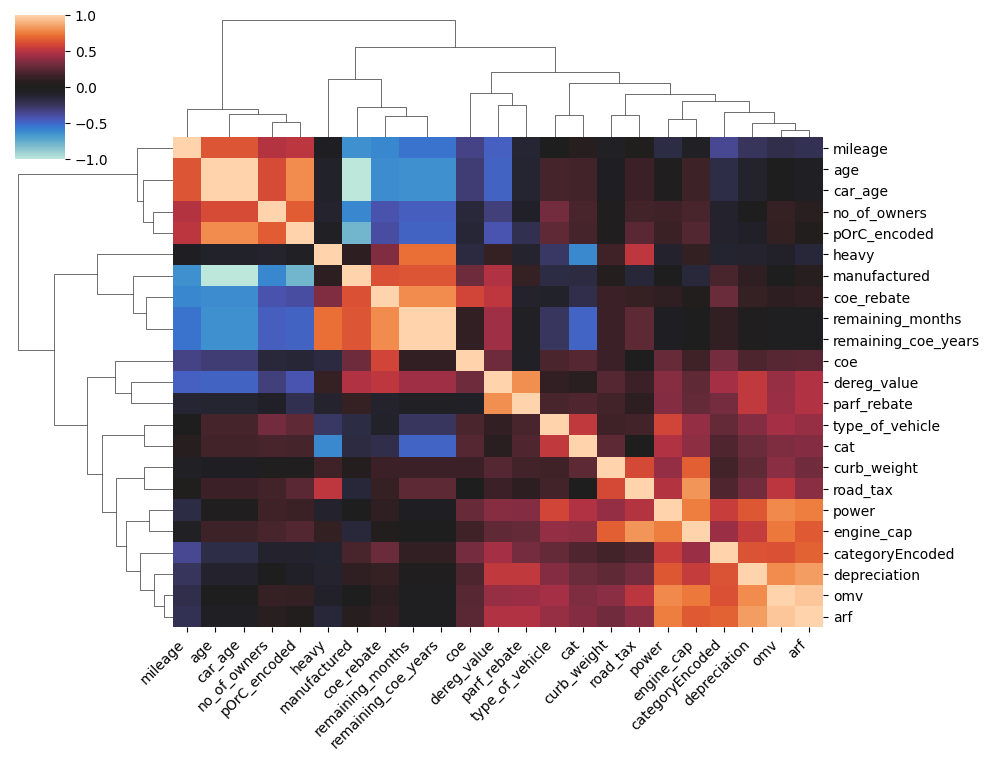

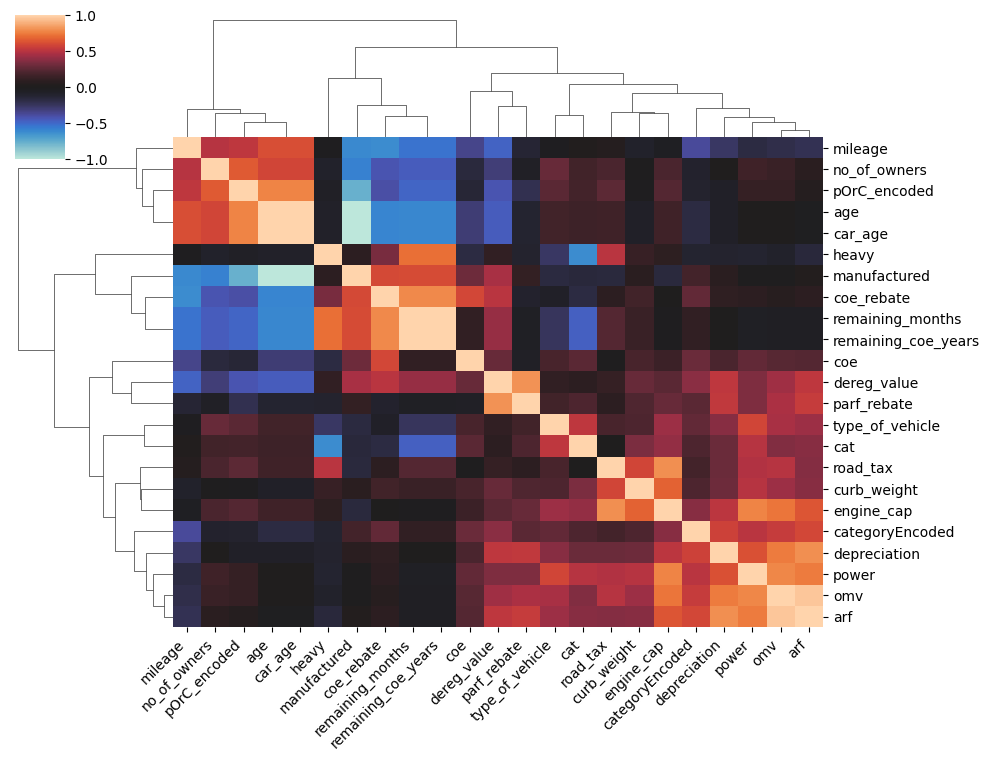

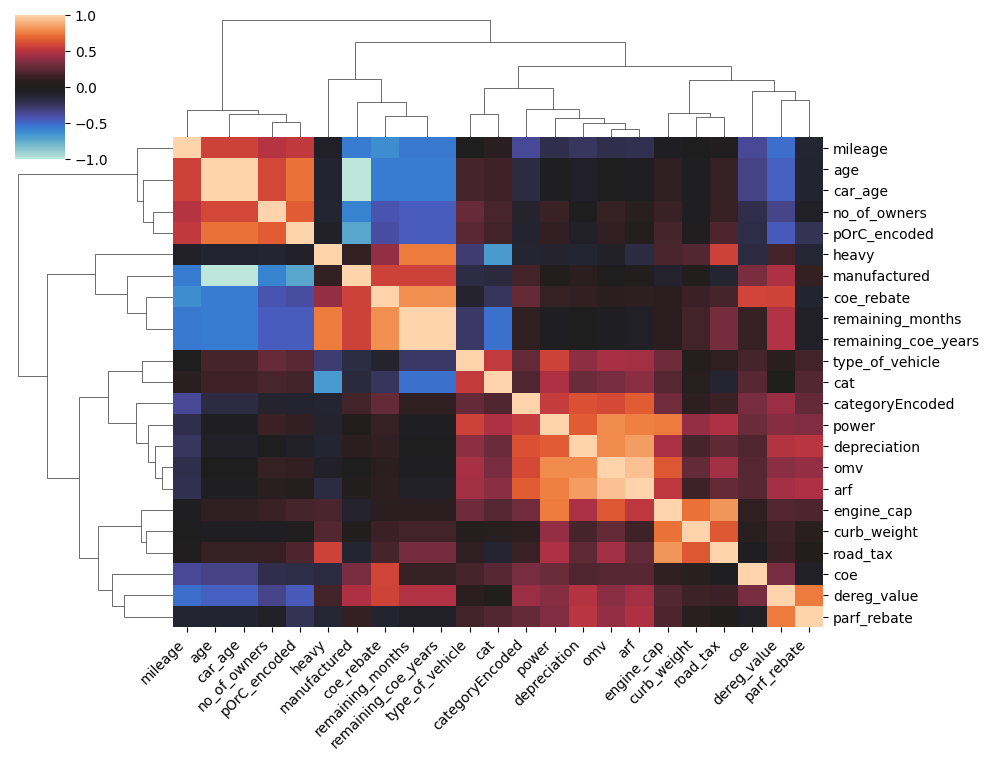

In [35]:


def corrplot(data, method="pearson", annot=True, figsize=(10, 8), **kwargs):

    # Calculate correlation matrix
    corr_matrix = data.corr(method=method, numeric_only=True)
    #print(corr_matrix)
    # Create the clustermap
    g = sns.clustermap(
        corr_matrix,
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        fmt=".2f",  # Format annotations to 2 decimal places
        figsize=figsize,
        **kwargs
    )
    
    # Rotate x-axis labels for better readability
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
    
    return g
# For X_train
corrplot(X_train, annot=False)

# For X_valid
corrplot(X_valid, annot=False)

# Show the plots
plt.show()
corrplot(test_df, annot=None)

### Model Train

In [44]:

from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Select numerical columns
numerical_columns = X_train.select_dtypes(include=['number']).columns.tolist()

# Define features and model parameters
numerical_features = numerical_columns  # Replace with your list of numerical feature names
n_neighbors = 5  # Adjust this based on previous tuning or specify a desired value
weights = 'uniform'  # 'uniform' or 'distance' depending on tuning
p = 2  # 1 for Manhattan distance, 2 for Euclidean distance (standard)

# Step 1: Preprocessing pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  # Scaling is important for KNN
])

preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, numerical_features)]
)

# Step 2: Model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p
    ))
])

# Step 3: Fit and evaluate on initial train/validation sets
model_pipeline.fit(X_train, y_train)
y_train_pred = model_pipeline.predict(X_train)
y_valid_pred = model_pipeline.predict(X_valid)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print(f"Initial Training RMSE: {train_rmse:.2f}")
print(f"Initial Validation RMSE: {valid_rmse:.2f}")

# Step 4: Define K-fold cross-validator and RMSE scorer
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Step 5: Perform K-fold cross-validation and capture fold-specific results
cv_results = cross_validate(
    model_pipeline,
    X_train,
    y_train,
    cv=kfold,
    scoring=rmse_scorer,
    return_train_score=True,
    n_jobs=-1
)

# Step 6: Calculate and print fold-specific RMSE
print("\nCross-Validation Fold Results:")
print("-" * 50)
test_rmse_scores = cv_results['test_score']
train_rmse_scores = cv_results['train_score']

# Plotting fold-specific scatter plots
for i, (train_rmse, test_rmse) in enumerate(zip(train_rmse_scores, test_rmse_scores), 1):
    print(f'Fold {i} - Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}')
    
    # Extract train/validation indices and fit model for each fold
    train_idx, valid_idx = list(kfold.split(X_train))[i-1]
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_valid_fold, y_valid_fold = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    # Fit model and get predictions for the current fold
    model_pipeline.fit(X_train_fold, y_train_fold)
    y_valid_pred_fold = model_pipeline.predict(X_valid_fold)
    
    # Plot fold-specific scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(y_valid_fold, y_valid_pred_fold, alpha=0.5)
    plt.plot([y_valid_fold.min(), y_valid_fold.max()], [y_valid_fold.min(), y_valid_fold.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Fold {i} - Actual vs Predicted\nRMSE: {test_rmse:.2f}')
    plt.tight_layout()
    plt.show()

# Step 7: Print Mean RMSE and calculate final cross-validated predictions
mean_rmse = test_rmse_scores.mean()
std_rmse = test_rmse_scores.std()
print(f'\nMean RMSE: {mean_rmse:.2f}')
print(f'Standard Deviation of RMSE: {std_rmse:.2f}')
print(f'RMSE Range: [{mean_rmse - 2 * std_rmse:.2f}, {mean_rmse + 2 * std_rmse:.2f}] (95% CI)')

# Step 8: Get cross-validated predictions
def get_cv_predictions(model, X, y, cv):
    predictions = np.zeros_like(y, dtype=float)
    for train_idx, valid_idx in cv.split(X):
        # Split the data for each fold
        X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
        X_valid_fold = X.iloc[valid_idx]
        
        # Fit and predict for current fold
        model.fit(X_train_fold, y_train_fold)
        predictions[valid_idx] = model.predict(X_valid_fold)
    
    return predictions

# Generate predictions across all folds
cv_predictions = get_cv_predictions(model_pipeline, X_train, y_train, kfold)

# Step 9: Calculate RMSE on cross-validated predictions
final_rmse = np.sqrt(mean_squared_error(y_train, cv_predictions))
print(f'\nFinal Cross-Validated RMSE: {final_rmse:.2f}')

# Step 10: Final scatter plot (Actual vs Predicted) for cross-validated predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_train, cv_predictions, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Final Cross-Validated Predictions\nRMSE: {final_rmse:.2f}')
plt.tight_layout()
plt.show()

# Step 11: RMSE Distribution Boxplot across folds
plt.figure(figsize=(8, 6))
plt.boxplot(test_rmse_scores, labels=['Test RMSE'])
plt.title('RMSE Scores Distribution Across Folds')
plt.ylabel('RMSE Score')
plt.grid(True)
plt.show()


'\nfrom sklearn.model_selection import KFold, cross_validate\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.neighbors import KNeighborsRegressor\nfrom sklearn.metrics import make_scorer, mean_squared_error\nimport numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# Select numerical columns\nnumerical_columns = X_train.select_dtypes(include=[\'number\']).columns.tolist()\n\n# Define features and model parameters\nnumerical_features = numerical_columns  # Replace with your list of numerical feature names\nn_neighbors = 5  # Adjust this based on previous tuning or specify a desired value\nweights = \'uniform\'  # \'uniform\' or \'distance\' depending on tuning\np = 2  # 1 for Manhattan distance, 2 for Euclidean distance (standard)\n\n# Step 1: Preprocessing pipeline for numerical features\nnumerical_transformer = Pipeline(steps

In [45]:

from sklearn.neighbors import KNeighborsRegressor

# Define the KNN parameter
n_neighbors = 5  # Set to the optimal value or any desired number of neighbors

# Updated model pipeline for KNN
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(n_neighbors=n_neighbors))
])

# Fit the model pipeline on the training data
model_pipeline.fit(X_train, y_train)



"\nfrom sklearn.neighbors import KNeighborsRegressor\n\n# Define the KNN parameter\nn_neighbors = 5  # Set to the optimal value or any desired number of neighbors\n\n# Updated model pipeline for KNN\nmodel_pipeline = Pipeline(steps=[\n    ('preprocessor', preprocessor),\n    ('model', KNeighborsRegressor(n_neighbors=n_neighbors))\n])\n\n# Fit the model pipeline on the training data\nmodel_pipeline.fit(X_train, y_train)\n"

### interpretability

In [46]:

import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import math

def plot_feature_importance(pipeline, X, top_n=10):
    """
    Plot feature importance for XGBoost model in a pipeline
    
    Parameters:
    pipeline: sklearn Pipeline containing XGBoost model
    X: original feature matrix/dataframe
    top_n: number of top features to display
    """
    # Get the XGBoost model from pipeline
    xgb_model = pipeline.named_steps['model']
    
    # Get feature importance using feature_importances_ attribute
    importance_values = xgb_model.feature_importances_
    
    # Get feature names from preprocessor
    preprocessor = pipeline.named_steps['preprocessor']
    if hasattr(preprocessor, 'get_feature_names_out'):
        feature_names = preprocessor.get_feature_names_out()
    else:
        feature_names = [f"feature_{i}" for i in range(len(importance_values))]
    
    # Create DataFrame for plotting
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_values
    })
    
    # Sort and get top N features
    importance_df = importance_df.sort_values('importance', ascending=True).tail(top_n)
    
    # Create horizontal bar plot
    plt.figure(figsize=(12, 6))
    bars = plt.barh(importance_df['feature'], importance_df['importance'])
    plt.title('XGBoost Feature Importance')
    plt.xlabel('Importance')
    
    # Add value labels on the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', 
                ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()

def plot_shap_summary(pipeline, X):
    """
    Create SHAP summary plot for feature impact
    
    Parameters:
    pipeline: sklearn Pipeline containing XGBoost model
    X: original feature matrix (will be preprocessed)
    """
    # Transform the data using the pipeline's preprocessor
    X_processed = pipeline.named_steps['preprocessor'].transform(X)
    
    # If preprocessor returns sparse matrix, convert to dense
    if hasattr(X_processed, 'toarray'):
        X_processed = X_processed.toarray()
    
    # Get the XGBoost model
    xgb_model = pipeline.named_steps['model']
    
    # Get feature names from preprocessor
    if hasattr(pipeline.named_steps['preprocessor'], 'get_feature_names_out'):
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    else:
        feature_names = [f"feature_{i}" for i in range(X_processed.shape[1])]
    
    # Calculate SHAP values
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_processed)
    
    # Create summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_processed, feature_names=feature_names, show=False)
    plt.tight_layout()

def plot_all_partial_dependence(pipeline, X):
    """
    Plot partial dependence for all features in a grid
    
    Parameters:
    pipeline: sklearn Pipeline containing XGBoost model
    X: original feature matrix
    """
    # Get the preprocessor and model
    preprocessor = pipeline.named_steps['preprocessor']
    xgb_model = pipeline.named_steps['model']
    
    # Transform the data
    X_processed = preprocessor.transform(X)
    if hasattr(X_processed, 'toarray'):
        X_processed = X_processed.toarray()
    
    # Get feature names
    if hasattr(preprocessor, 'get_feature_names_out'):
        feature_names = preprocessor.get_feature_names_out()
    else:
        feature_names = [f"feature_{i}" for i in range(X_processed.shape[1])]
    
    # Calculate grid dimensions
    n_features = len(feature_names)
    n_cols = min(3, n_features)  # Maximum 3 columns
    n_rows = math.ceil(n_features / n_cols)
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Plot partial dependence for each feature
    for idx, (ax, feature_name) in enumerate(zip(axes, feature_names)):
        # Generate feature values to evaluate
        feature_values = np.linspace(
            X_processed[:, idx].min(), 
            X_processed[:, idx].max(), 
            100
        )
        
        # Create temporary datasets for prediction
        predictions = []
        for value in feature_values:
            X_temp = X_processed.copy()
            X_temp[:, idx] = value
            pred = xgb_model.predict(X_temp)
            predictions.append(pred.mean())
        
        # Plot
        ax.plot(feature_values, predictions)
        ax.set_xlabel(feature_name)
        ax.set_ylabel('Predicted Value')
        ax.set_title(f'Partial Dependence: {feature_name}')
        ax.grid(True)
    
    # Remove empty subplots if any
    for idx in range(len(feature_names), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()

def get_feature_names(pipeline):
    """
    Get feature names after preprocessing
    
    Parameters:
    pipeline: sklearn Pipeline containing preprocessor
    
    Returns:
    list of feature names after preprocessing
    """
    preprocessor = pipeline.named_steps['preprocessor']
    if hasattr(preprocessor, 'get_feature_names_out'):
        return preprocessor.get_feature_names_out()
    return None
# After fitting your pipeline

# Plot feature importance
plot_feature_importance(model_pipeline, X_train, top_n=10)

# Plot SHAP summary
plot_shap_summary(model_pipeline, X_train)

# Plot partial dependence for all features
plot_all_partial_dependence(model_pipeline, X_train)

plt.show()


'\nimport xgboost as xgb\nimport numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport shap\nimport math\n\ndef plot_feature_importance(pipeline, X, top_n=10):\n    """\n    Plot feature importance for XGBoost model in a pipeline\n    \n    Parameters:\n    pipeline: sklearn Pipeline containing XGBoost model\n    X: original feature matrix/dataframe\n    top_n: number of top features to display\n    """\n    # Get the XGBoost model from pipeline\n    xgb_model = pipeline.named_steps[\'model\']\n    \n    # Get feature importance using feature_importances_ attribute\n    importance_values = xgb_model.feature_importances_\n    \n    # Get feature names from preprocessor\n    preprocessor = pipeline.named_steps[\'preprocessor\']\n    if hasattr(preprocessor, \'get_feature_names_out\'):\n        feature_names = preprocessor.get_feature_names_out()\n    else:\n        feature_names = [f"feature_{i}" for i in range(len(importance_values))]\n    \n  

### Predict 

In [47]:
test_predictions = model_pipeline.predict(test_df)

In [48]:
output = pd.DataFrame({'Id': test_df.index, 'Predicted': test_predictions})
print(output)
print(test_predictions.size)
output.head()


        Id      Predicted
0        0   27454.397859
1        1   43481.896666
2        2  149629.989984
3        3   79728.853404
4        4   23697.192077
...    ...            ...
9995  9995  120821.025343
9996  9996  183638.861030
9997  9997   66014.256343
9998  9998   77830.864636
9999  9999   64858.666272

[10000 rows x 2 columns]
10000


,Id,Predicted
0,0,27454.397859
1,1,43481.896666
2,2,149629.989984
3,3,79728.853404
4,4,23697.192077


In [49]:
output.to_csv('predictions_final.csv', index=False)